# Load Zarr files

This tutorial will show some examples on how to load zarr files on coast.
It will include:
- Creation of a Gridded object
- Loading data into the Gridded object.
- Combining Gridded output and Gridded domain data.
- Interrogating the Gridded object.
- Basic manipulation and subsetting
- Looking at the data with matplotlib

### Requirements

Coast also has the capability to allow you to open zarr files In order to do that, you need to install first the library zarr:

`pip install zarr xarray[complete] aiohttp requests`

`!IMPORTANT!`: this environment already has these packages installed

After that, you can open the datasets

### Import

Begin by importing COAsT and define some file paths for NEMO output data and a NEMO domain, as an example of model data suitable for the Gridded object.

In [12]:
import warnings 
warnings.filterwarnings('ignore')
import coast
import matplotlib.pyplot as plt
import datetime
import numpy as np
import xarray as xr
import zarr

root = "../../"
fn_config_t_grid = root + "./config/example_nemo_monthly_climate.json"

# Define some file paths
fn_nemo_dom_mask = "https://noc-msm-o.s3-ext.jc.rl.ac.uk/n06-coast-testing/mask.zarr"
fn_nemo_dom_mesh_zgr = "https://noc-msm-o.s3-ext.jc.rl.ac.uk/n06-coast-testing/mesh_zgr.zarr"
fn_nemo_dom_mesh_hgr = "https://noc-msm-o.s3-ext.jc.rl.ac.uk/n06-coast-testing/mesh_hgr.zarr"
fn_nemo_dat_t = "https://noc-msm-o.s3-ext.jc.rl.ac.uk/n06-coast-testing/n06_T.zarr"
fn_nemo_dat_u = "https://noc-msm-o.s3-ext.jc.rl.ac.uk/n06-coast-testing/n06_U.zarr"
fn_nemo_dat_v = "https://noc-msm-o.s3-ext.jc.rl.ac.uk/n06-coast-testing/n06_V.zarr"


### Open the zarr files as a XARRAY

The zarr files that we are using in this example do not have all the variables on the same file. Because of that, we need to open each file separately and then add the variables to a central file

In [14]:
dom = xr.open_zarr(fn_nemo_dom_mask)
mesh_zgr = xr.open_zarr(fn_nemo_dom_mesh_zgr)
mesh_hgr = xr.open_zarr(fn_nemo_dom_mesh_hgr)

In [15]:
for var_name in mesh_zgr.data_vars:
    dom[var_name] = mesh_zgr[var_name]
for var_name in mesh_hgr.data_vars:
    dom[var_name] = mesh_hgr[var_name]

In [16]:
u_grid = xr.open_zarr(fn_nemo_dat_u)
u_grid = u_grid.isel(time_counter=slice(0,119)).rename({'depthu': 'depth'})
v_grid = xr.open_zarr(fn_nemo_dat_v)
v_grid = v_grid.isel(time_counter=slice(0,119)).rename({'depthv': 'depth'})
t_grid = xr.open_zarr(fn_nemo_dat_t)
t_grid = t_grid.rename({'deptht': 'depth'})

In [17]:
for var_name in u_grid.data_vars:
    t_grid[var_name] = u_grid[var_name]
for var_name in v_grid.data_vars:
    t_grid[var_name] = v_grid[var_name]

In [18]:
#Uncomment to see the data
# dom

In [19]:
#Uncomment to see the data
# t_grid

### Slice the zarr files

Because zarr files are optimized for cloud, when we instantiate an xarray dataset, we do not open the zarr by it self. We only open some metadata related to the file. The files will only be downloaed when we need to perform some processing on the data

In [20]:
dom = dom.isel(y=slice(500, 700), x=slice(1000,1200))

In [21]:
t_grid = t_grid.isel(y=slice(500, 700), x=slice(1000,1200), time_counter=slice(0,24))

### Loading and Interrogating

We can create a new Gridded object by simple calling `coast.Gridded()`. By passing this a NEMO data file and a NEMO domain file, COAsT will combine the two into a single xarray dataset within the Gridded object. Each individual Gridded object should be for a specified NEMO grid type, which is specified in a configuration file which is also passed as an argument. The Dask library is switched on by default, chunking can be specified in the configuration file.

In [22]:
nemo_t = coast.Gridded(fn_data= t_grid, fn_domain = dom, config=fn_config_t_grid)

`!IMPORTANT!`: this dataset does not contain bathymetry data.

Our new Gridded object `nemo_t` contains a variable called dataset, which holds information on the two files we passed. Let’s have a look at this:

In [23]:
nemo_t.dataset # uncomment to print data object summary

<xarray.Dataset> Size: 2GB
Dimensions:       (depth: 75, t_dim: 24, y_dim: 200, x_dim: 200, z_dim: 75)
Coordinates:
  * depth         (depth) float32 300B 0.5058 1.556 ... 5.698e+03 5.902e+03
  * time          (t_dim) datetime64[ns] 192B 1960-01-06T12:00:00 ... 1961-12...
    longitude     (y_dim, x_dim) float32 160kB dask.array<chunksize=(200, 82), meta=np.ndarray>
    latitude      (y_dim, x_dim) float32 160kB dask.array<chunksize=(200, 82), meta=np.ndarray>
    depth_0       (z_dim, y_dim, x_dim) float64 24MB 0.5 0.5 ... 5.86e+03
Dimensions without coordinates: t_dim, y_dim, x_dim, z_dim
Data variables: (12/29)
    e3t           (t_dim, depth, y_dim, x_dim) float32 288MB dask.array<chunksize=(1, 5, 77, 154), meta=np.ndarray>
    mldkz5        (t_dim, y_dim, x_dim) float32 4MB dask.array<chunksize=(1, 77, 154), meta=np.ndarray>
    mldr10_1      (t_dim, y_dim, x_dim) float32 4MB dask.array<chunksize=(1, 77, 154), meta=np.ndarray>
    potemp        (t_dim, depth, y_dim, x_dim) float32 288MB dask.array<chunksize=(1, 5, 77, 154), meta=np.ndarray>
    rsntds        (t_dim, y_dim, x_dim) float32 4MB dask.array<chunksize=(1, 77, 154), meta=np.ndarray>
    salin         (t_dim, depth, y_dim, x_dim) float32 288MB dask.array<chunksize=(1, 5, 77, 154), meta=np.ndarray>
    ...            ...
    bathymetry    (y_dim, x_dim) float64 320kB dask.array<chunksize=(76, 82), meta=np.ndarray>
    e1            (y_dim, x_dim) float64 320kB dask.array<chunksize=(76, 82), meta=np.ndarray>
    e2            (y_dim, x_dim) float64 320kB dask.array<chunksize=(76, 82), meta=np.ndarray>
    e3_0          (z_dim, y_dim, x_dim) float64 24MB dask.array<chunksize=(5, 76, 82), meta=np.ndarray>
    mask          (z_dim, y_dim, x_dim) int8 3MB dask.array<chunksize=(10, 200, 82), meta=np.ndarray>
    bottom_level  (y_dim, x_dim) int16 80kB dask.array<chunksize=(200, 81), meta=np.ndarray>
Attributes:
    DOMAIN_number_total:  80
    DOMAIN_size_global:   [4322, 3059]
    conventions:          CF-1.1
    description:          ocean T grid variables
    ibegin:               1
    jbegin:               1
    name:                 ORCA0083-N06_1m_19591222_19601231
    ni:                   4322
    nj:                   39
    production:           An IPSL model
    timeStamp:            2014-Dec-03 05:19:35 GMT

This is an xarray dataset, which has all the information on netCDF style structures. You can see dimensions, coordinates and data variables. At the moment, none of the actual data is loaded to memory and will remain that way until it needs to be accessed.

As it is a zarr file, it will only get any data if you apply `compute()` on the data:

In [24]:
ssh = nemo_t.dataset.ssh
ssh.compute()
# ssh # uncomment to print data object summary

<xarray.DataArray 'ssh' (t_dim: 24, y_dim: 200, x_dim: 200)> Size: 4MB
array([[[-1.6210064 , -1.6217471 , -1.6231693 , ..., -1.5842544 ,
         -1.5886359 , -1.5930159 ],
        [-1.6208621 , -1.6217225 , -1.6233234 , ..., -1.5888053 ,
         -1.5935609 , -1.5981766 ],
        [-1.621304  , -1.6223003 , -1.6240481 , ..., -1.5930148 ,
         -1.5981003 , -1.6029042 ],
        ...,
        [-0.98735386, -0.9597808 , -0.931632  , ..., -0.6270069 ,
         -0.6278365 , -0.6290987 ],
        [-1.0102477 , -0.9808094 , -0.9505175 , ..., -0.63027424,
         -0.6316009 , -0.63331974],
        [-1.0307174 , -0.99985355, -0.96790063, ..., -0.63465285,
         -0.6367161 , -0.6389442 ]],

       [[-1.6141921 , -1.6149583 , -1.6157647 , ..., -1.5382599 ,
         -1.5428585 , -1.5479578 ],
        [-1.6137543 , -1.614481  , -1.6153185 , ..., -1.5421394 ,
         -1.5469443 , -1.5521828 ],
        [-1.6131831 , -1.6138711 , -1.6147525 , ..., -1.5456467 ,
         -1.5506693 , -1.5560651 ],
...
        [-0.5291973 , -0.53182423, -0.537423  , ..., -0.7970734 ,
         -0.8119881 , -0.82499063],
        [-0.53454167, -0.5373199 , -0.54308665, ..., -0.77014893,
         -0.7829233 , -0.7941438 ],
        [-0.53937477, -0.5424393 , -0.5484757 , ..., -0.7462123 ,
         -0.7570849 , -0.76668566]],

       [[-1.6791433 , -1.6803815 , -1.6808515 , ..., -1.5127497 ,
         -1.5175854 , -1.5226325 ],
        [-1.679447  , -1.6804127 , -1.6806444 , ..., -1.5093309 ,
         -1.5140619 , -1.5190879 ],
        [-1.6797307 , -1.6804144 , -1.6804197 , ..., -1.5054852 ,
         -1.5097626 , -1.5145139 ],
        ...,
        [-0.67837346, -0.6714207 , -0.6632468 , ..., -0.77248365,
         -0.79867   , -0.82295316],
        [-0.6826826 , -0.6778399 , -0.67128325, ..., -0.74587363,
         -0.7708025 , -0.794183  ],
        [-0.68843955, -0.68585885, -0.681205  , ..., -0.71919113,
         -0.7428356 , -0.7651531 ]]], dtype=float32)
Coordinates:
  * time       (t_dim) datetime64[ns] 192B 1960-01-06T12:00:00 ... 1961-12-13...
    longitude  (y_dim, x_dim) float32 160kB 156.2 156.3 156.4 ... 172.8 172.8
    latitude   (y_dim, x_dim) float32 160kB -63.49 -63.49 ... -55.07 -55.07
Dimensions without coordinates: t_dim, y_dim, x_dim
Attributes:
    interval_operation:  300s
    interval_write:      1mo
    long_name:           sea_surface_height_above_geoid
    online_operation:    average
    units:               m

Or as a numpy array:

In [26]:
ssh_np = ssh.values
ssh_np.shape # uncomment to print data object summary

(24, 200, 200)

Then lets plot up a single time snapshot of ssh using matplotlib:

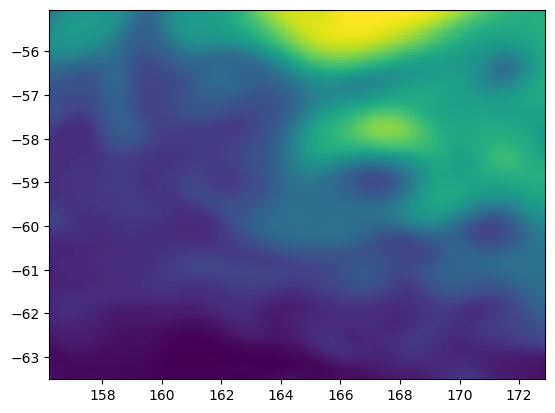

In [27]:
plt.pcolormesh(nemo_t.dataset.longitude, nemo_t.dataset.latitude, nemo_t.dataset.ssh[0])